## Preliminary - Install and Import Library

In [1]:
#!pip install pyspark

In [2]:
#!pip install pandas

In [3]:
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import *
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.functions import *

In [5]:
# Check PySpark Version
print(pyspark.__version__)

3.2.1


## Access Yelp Data from MongoDB

In [6]:
# Connect PySpark and MongoDB using connector
spark = SparkSession\
        .builder\
        .config('spark.jars.packages','org.mongodb.spark:mongo-spark-connector_2.12:2.4.2')\
        .getOrCreate()

/home/student/yelp_case_study/yelp_case_study_env/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [7]:
# Load JSON data files to PySpark
load_start = datetime.now()

business = spark.read.format('com.mongodb.spark.sql.DefaultSource').option("uri", "mongodb://localhost/yelp.business").load()
user = spark.read.format('com.mongodb.spark.sql.DefaultSource').option("uri", "mongodb://localhost/yelp.user").load()
tip = spark.read.format('com.mongodb.spark.sql.DefaultSource').option("uri", "mongodb://localhost/yelp.tip").load()
review = spark.read.format('com.mongodb.spark.sql.DefaultSource').option("uri", "mongodb://localhost/yelp.review").load()
checkin = spark.read.format('com.mongodb.spark.sql.DefaultSource').option("uri", "mongodb://localhost/yelp.checkin").load()

In [8]:
# Duration of Execution Time - Loading Data
duration_load_time = (datetime.now()-load_start).total_seconds()
print("Time taken to load data : {}".format(duration_load_time))

Time taken to load data : 9.623121


## Check schema of Yelp Data

In [9]:
print(business.printSchema())

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: string (nullable = true)
 |    |

In [10]:
print(checkin.printSchema())

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)

None


In [11]:
print(user.printSchema())

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: integer (nullable = true)
 |-- compliment_cute: integer (nullable = true)
 |-- compliment_funny: integer (nullable = true)
 |-- compliment_hot: integer (nullable = true)
 |-- compliment_list: integer (nullable = true)
 |-- compliment_more: integer (nullable = true)
 |-- compliment_note: integer (nullable = true)
 |-- compliment_photos: integer (nullable = true)
 |-- compliment_plain: integer (nullable = true)
 |-- compliment_profile: integer (nullable = true)
 |-- compliment_writer: integer (nullable = true)
 |-- cool: integer (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: integer (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- useful: integer (nullable = true)
 |-- user_id: string (nullable 

In [12]:
print(review.printSchema())

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- cool: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: integer (nullable = true)
 |-- user_id: string (nullable = true)

None


In [13]:
print(tip.printSchema())

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- compliment_count: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)

None


## Quick Query - Count 

In [14]:
print('Number of business listings:', business.count())

Number of business listings: 160585


In [15]:
print('Number of tips:', tip.count())

Number of tips: 1162119


In [16]:
print('Number of reviews:', review.count())

Number of reviews: 8635403


In [17]:
print('Number of checkins:', checkin.count())

Number of checkins: 138876


In [18]:
print('Number of users:', user.count())

Number of users: 2189457


## Quick Query - Explore data (Reviews, Business Listings)

In [19]:
review.groupBy('stars').agg(count('review_id').alias('count')).sort('stars').show()

+-----+-------+
|stars|  count|
+-----+-------+
|  1.0|1262800|
|  2.0| 711378|
|  3.0| 926656|
|  4.0|1920037|
|  5.0|3814532|
+-----+-------+



In [20]:
rating = business.select('stars')
group_rating = rating.groupby('stars').count()
rating_top = group_rating.sort('count',ascending=False)
rating_top.show(truncate=False)

+-----+-----+
|stars|count|
+-----+-----+
|4.0  |34056|
|3.5  |28835|
|4.5  |28072|
|3.0  |21583|
|5.0  |19953|
|2.5  |13720|
|2.0  |8523 |
|1.5  |4157 |
|1.0  |1686 |
+-----+-----+



In [21]:
category = business.select('categories')
individual_category = category.select(explode(split('categories', ',')).alias('category'))
grouped_category = individual_category.groupby('category').count()
top_category = grouped_category.sort('count',ascending=False)
top_category.show(500,truncate=False)

+---------------------------------+-----+
|category                         |count|
+---------------------------------+-----+
| Restaurants                     |36340|
| Food                            |22094|
| Shopping                        |20056|
|Restaurants                      |14423|
| Home Services                   |12001|
| Beauty & Spas                   |11633|
| Health & Medical                |11390|
| Nightlife                       |9808 |
| Local Services                  |9299 |
| Bars                            |8914 |
| Event Planning & Services       |7617 |
|Food                             |7375 |
| Active Life                     |7039 |
| Automotive                      |6785 |
|Shopping                         |6149 |
| Coffee & Tea                    |5735 |
| Sandwiches                      |5697 |
| American (Traditional)          |5235 |
| Fashion                         |5231 |
|Beauty & Spas                    |4941 |
| Breakfast & Brunch              

## Retail Sector -  Drugstores (Demostration Purpose)

In [22]:
# Assuming you want to run retail business for DrugStores in Boston
drugstores = business.drop("attributes","hours").filter((col("categories").like("%Drugstores%")) & (col("city") == 'Boston'))
drugstores.show(5)

+--------------------+--------------------+--------------------+--------------------+------+-------+-------------+--------------+-----------------+-----------+------------+-----+-----+
|                 _id|             address|         business_id|          categories|  city|is_open|     latitude|     longitude|             name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------+-------+-------------+--------------+-----------------+-----------+------------+-----+-----+
|{61f28efed1fa5606...|  155 Charles Street|eorUPZ003bDIQ3Ti6...|Photography Store...|Boston|      1|   42.3606348|    -71.070506|     CVS Pharmacy|      02114|          16|  3.5|   MA|
|{61f28efed1fa5606...|900 Commonwealth ...|Vd8A-sEv_FvlDW0tD...|Shopping, Drugsto...|Boston|      1|    42.350554|    -71.116164|     CVS Pharmacy|      02215|          16|  2.0|   MA|
|{61f28efed1fa5606...|        75 Spring St|mgTgQK47y_SteZWAd...|Drugstores,

### Drugstores business_id list

In [23]:
drugstores_list= drugstores.select('business_id').rdd.map(lambda x : x[0]).collect()

### Subset of Reviews that only include Drugstores business_id list

In [24]:
reviews_drugstores = review.filter(review.business_id.isin(drugstores_list))

In [25]:
reviews_drugstores.show()

+--------------------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|                 _id|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|{61f29025d1fa5606...|Vd8A-sEv_FvlDW0tD...|   0|2015-12-21 19:13:23|    0|tull0f4F86QYL8Chg...|  1.0|I doubt the pharm...|     1|aQP5vjBaPb3kWxBKU...|
|{61f29026d1fa5606...|Vd8A-sEv_FvlDW0tD...|   0|2010-03-14 23:35:43|    0|C3uSNE2uhRafXm1SH...|  4.0|I really like thi...|     1|RR0rWi3abQoEPaVZM...|
|{61f29028d1fa5606...|Vd8A-sEv_FvlDW0tD...|   0|2012-05-02 14:03:05|    0|Cfm-7VIIdNL-gZcPm...|  1.0|This CVS is about...|     3|SVr5G7kQtjvoIohCb...|
|{61f29029d1fa5606...|Vd8A-sEv_FvlDW0tD...|   2|2009-03-12 04:01:19|    2|jGs2dv6u2sQNgeFDm...

### WordCloud of reviews for DrugStores in Boston

In [26]:
from collections import Counter 
# wordcloud in python
from wordcloud import WordCloud, STOPWORDS 

import re 
import string
import nltk # preprocessing text
from textblob import TextBlob

In [27]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
i = nltk.corpus.stopwords.words('english')
# punctuations to remove
j = list(string.punctuation)
# finally let's combine all of these
stopwords = set(i).union(j).union(('thiswas','wasbad','thisis','wasgood','isbad','isgood','theres','there'))

In [29]:
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  
    x = [w for w in x.split() if w not in set(stopwords)]  
    return ' '.join(x)

In [30]:
# Convert Spark DataFrame to Panda DataFrame Temporarily
reviews_drugstores_temp = reviews_drugstores.toPandas()

In [31]:
reviews_drugstores_temp['text_processed'] = reviews_drugstores_temp['text'].apply(preprocess)

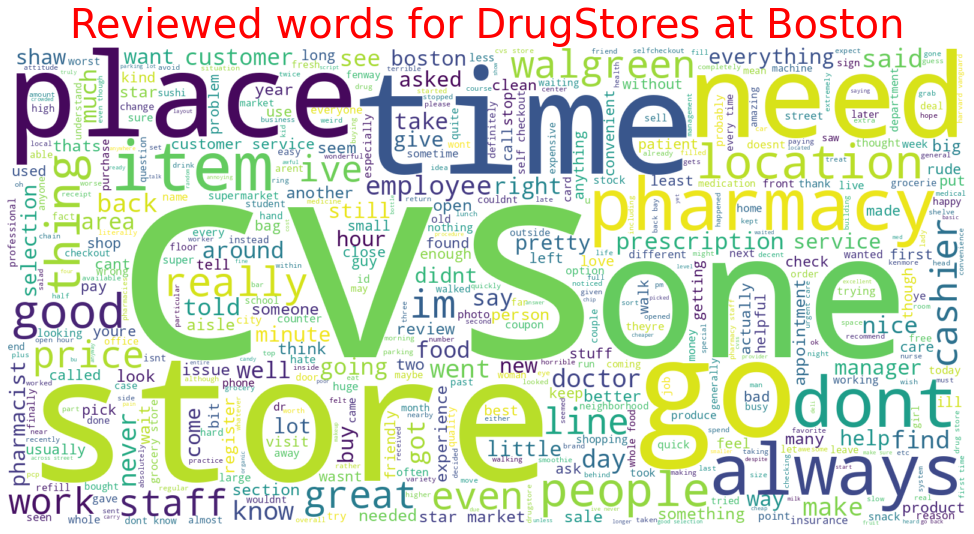

In [32]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=500, background_color='white',)
wordcloud.generate(str(set(reviews_drugstores_temp['text_processed'])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Reviewed words for DrugStores at Boston", fontsize=40,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

### Spatial Data on Boston Map for DrugStores

In [33]:
# Check max and min of longitude and latitude
drugstores.agg({'latitude': 'min'}).show()
drugstores.agg({'latitude': 'max'}).show()
drugstores.agg({'longitude': 'min'}).show()
drugstores.agg({'longitude': 'max'}).show()

+-------------+
|min(latitude)|
+-------------+
|   42.2418218|
+-------------+

+-------------+
|max(latitude)|
+-------------+
|     42.36546|
+-------------+

+--------------+
|min(longitude)|
+--------------+
|-71.1630222672|
+--------------+

+--------------+
|max(longitude)|
+--------------+
|-71.0461409067|
+--------------+



In [35]:
df = drugstores.toPandas()

In [36]:
# Check the columns
df.columns

Index(['_id', 'address', 'business_id', 'categories', 'city', 'is_open',
       'latitude', 'longitude', 'name', 'postal_code', 'review_count', 'stars',
       'state'],
      dtype='object')

In [37]:
# Load map
ruh_m = plt.imread('Boston_drugstores.png')

In [38]:
BBox = ((df.longitude.min(),   df.longitude.max(),      
         df.latitude.min(), df.latitude.max()))

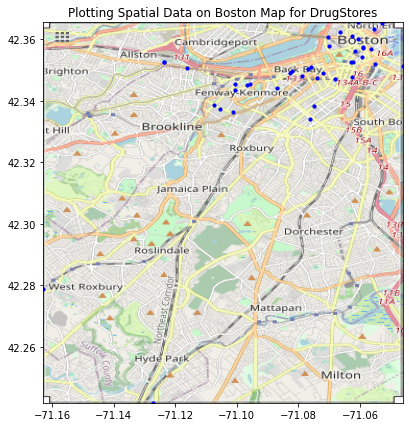

In [39]:
# Visualize the scatter of Woman's Clothing retail shops in Boston
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df.longitude, df.latitude, zorder=1, alpha= 1, c='b', s=10)
ax.set_title('Plotting Spatial Data on Boston Map for DrugStores')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

## Retail Sector -  Clothings (Demostration Purpose)

In [40]:
# Assuming you want to run retail business for Woman's clothing in Boston
woman_clothing = business.drop("attributes","hours").filter((col("categories").like("%Women%Clothing%")) & (col("city") == 'Boston'))
woman_clothing.show(5)

+--------------------+---------------+--------------------+--------------------+------+-------+----------+-----------+--------------------+-----------+------------+-----+-----+
|                 _id|        address|         business_id|          categories|  city|is_open|  latitude|  longitude|                name|postal_code|review_count|stars|state|
+--------------------+---------------+--------------------+--------------------+------+-------+----------+-----------+--------------------+-----------+------------+-----+-----+
|{61f28efdd1fa5606...| 329 Newbury St|ABrcH2VyNxv5jrIYf...|Women's Clothing,...|Boston|      1| 42.348812| -71.086375|            Madewell|      02115|          38|  4.0|   MA|
|{61f28efdd1fa5606...| 106 Charles St|-3FjSLA_bfyEY_qMT...|Fashion, Local Se...|Boston|      1|42.3588874|-71.0709245|The Designers Lea...|      02114|          25|  3.5|   MA|
|{61f28efdd1fa5606...|75 State Street|K1ulLDuLcMrFnMY05...|Shopping, Men's C...|Boston|      1|42.3585849|-71.05498

### Woman's Clothing Retail business_id list

In [41]:
woman_clothing_list= woman_clothing.select('business_id').rdd.map(lambda x : x[0]).collect()

### Subset of Reviews that only include Woman's Clothing Retail business_id list

In [42]:
reviews_woman_clothing = review.filter(review.business_id.isin(woman_clothing_list))

In [43]:
reviews_woman_clothing.show(5)

+--------------------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|                 _id|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|{61f29024d1fa5606...|nOQn6TPDyNjX3M4q_...|   0|2008-12-04 01:40:03|    2|obGZKTutPzMsElHq8...|  1.0|Hah! They shut do...|     0|O-wZNKX9zSMj317qx...|
|{61f29024d1fa5606...|ARUNI6MX3rRqEwUxO...|   0|2014-04-19 14:39:51|    0|ZMXC0it7-P1jM0AcM...|  5.0|i love this store...|     0|1htFioarYIjI6XhJQ...|
|{61f29024d1fa5606...|gQ8kUsN3CNBbkuUr5...|   0|2011-09-25 18:48:24|    0|JUZNBcFXMitcwMkU0...|  5.0|Loved my suit! I'...|     0|OTyBUeV85PXohVVNs...|
|{61f29024d1fa5606...|ARUNI6MX3rRqEwUxO...|   0|2018-10-04 17:41:11|    0|759Vc-QD6wpv_NKf5...

### WordCloud of reviews for Woman's Clothing Retail in Boston

In [44]:
from collections import Counter 
# wordcloud in python
from wordcloud import WordCloud, STOPWORDS 

import re 
import string
import nltk # preprocessing text
from textblob import TextBlob

In [45]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
i = nltk.corpus.stopwords.words('english')
# punctuations to remove
j = list(string.punctuation)
# finally let's combine all of these
stopwords = set(i).union(j).union(('thiswas','wasbad','thisis','wasgood','isbad','isgood','theres','there'))

In [47]:
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  
    x = [w for w in x.split() if w not in set(stopwords)]  
    return ' '.join(x)

In [48]:
# Convert Spark DataFrame to Panda DataFrame Temporarily
reviews_woman_clothing_temp = reviews_woman_clothing.toPandas()

In [49]:
reviews_woman_clothing_temp['text_processed'] = reviews_woman_clothing_temp['text'].apply(preprocess)

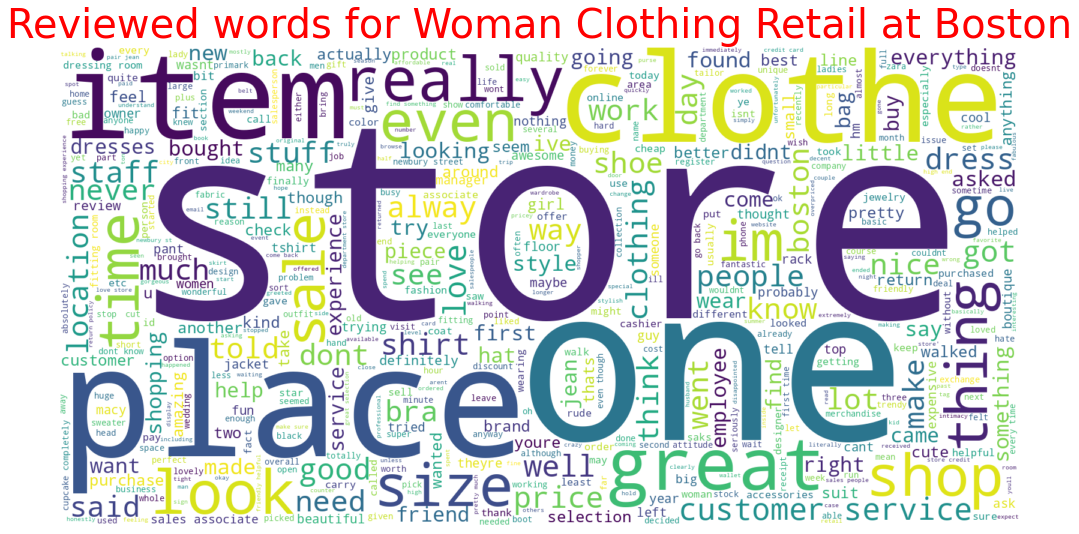

In [50]:
wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=500, background_color='white',)
wordcloud.generate(str(set(reviews_woman_clothing_temp['text_processed'])))
# declare our figure 
plt.figure(figsize=(20,10))
plt.title("Reviewed words for Woman Clothing Retail at Boston", fontsize=40,color='Red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

### Spatial Data on Boston Map for Woman's Clothing Retail

In [51]:
# Check max and min of longitude and latitude
woman_clothing.agg({'latitude': 'min'}).show()
woman_clothing.agg({'latitude': 'max'}).show()
woman_clothing.agg({'longitude': 'min'}).show()
woman_clothing.agg({'longitude': 'max'}).show()

+-------------+
|min(latitude)|
+-------------+
|    42.307588|
+-------------+

+-------------+
|max(latitude)|
+-------------+
|42.3860696226|
+-------------+

+--------------+
|min(longitude)|
+--------------+
|   -71.1565448|
+--------------+

+--------------+
|max(longitude)|
+--------------+
|-71.0179060027|
+--------------+



In [52]:
df = woman_clothing.toPandas()

In [53]:
# Check the columns
df.columns

Index(['_id', 'address', 'business_id', 'categories', 'city', 'is_open',
       'latitude', 'longitude', 'name', 'postal_code', 'review_count', 'stars',
       'state'],
      dtype='object')

In [54]:
# Load map
ruh_m = plt.imread('Boston_woman_clothing.png')

In [55]:
BBox = ((df.longitude.min(),   df.longitude.max(),      
         df.latitude.min(), df.latitude.max()))

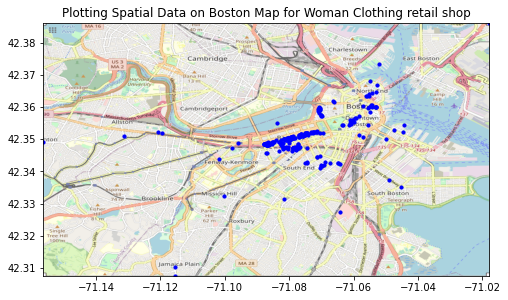

In [56]:
# Visualize the scatter of Woman's Clothing retail shops in Boston
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df.longitude, df.latitude, zorder=1, alpha= 1, c='b', s=10)
ax.set_title('Plotting Spatial Data on Boston Map for Woman Clothing retail shop')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')